# Projet de Plateforme de trading
#### Projet réalisé par Chloé Trovoada

Dans un premier temps créons un bouton qui affiche et cache les messages Warnings.

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

## Stocks selection
L’objectif de ce projet est de prédire les variations de l’Eurostoxx 50.

    Récupérer le fichier Eurostoxx50_EOD_Clean.csv dans python
    Générer un arbre de décision en vue de prédire les variations entre j et j+1 de l’Eurostoxx 50 (SX5E) en fonction des variations entre j et j-1 de chaque stock
    Améliorer la prédiction à l’aide du boosting/d’une forêt aléatoire
    La prédiction est-elle meilleure qu’en utilisant une multi-régression?
    Générer les 'features importance'
### Récupérer le fichier Eurostoxx50_EOD_Clean.csv dans python

In [2]:
import pandas as pd

mydateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%Y %H:%M")

data = pd.read_csv('/Users/chloetrvd/Documents/ESILV/PLATEFORME DE TRADING/Eurostoxx50_EOD_Clean.csv', sep=';', decimal=',', index_col='Dates', parse_dates=['Dates'], date_parser=mydateparser)
data.head()

,ABI BB Equity,AD NA Equity,ADS GY Equity,AI FP Equity,AIR FP Equity,AMS SQ Equity,ASML NA Equity,BAS GY Equity,BAYN GY Equity,BBVA SQ Equity,...,SAN FP Equity,SAN SQ Equity,SAP GY Equity,SIE GY Equity,SU FP Equity,TEF SQ Equity,URW NA Equity,VIV FP Equity,VOW3 GY Equity,SX5E Index
Dates,,,,,,,,,,,,,,,,,,,,,
2019-02-27,65.86,22.60,213.1,109.50,113.46,68.62,161.68,67.28,69.28,5.38,...,72.73,4.20,93.81,96.68,68.32,7.54,143.76,24.39,151.66,3282.77
2019-02-28,68.55,22.68,213.6,109.65,113.60,66.20,161.12,66.99,70.28,5.47,...,73.50,4.30,94.20,96.13,68.42,7.59,142.00,25.70,150.90,3298.26
2019-03-01,72.80,22.81,215.9,110.45,113.90,66.40,161.46,68.06,71.43,5.38,...,74.00,4.25,94.89,96.94,69.06,7.48,141.80,25.62,154.18,3312.10
2019-03-04,71.65,22.26,215.8,109.90,114.02,65.86,163.88,68.31,72.35,5.34,...,75.03,4.24,94.68,97.42,69.98,7.42,143.74,25.45,154.24,3317.12
2019-03-05,72.68,22.62,216.7,110.85,113.24,65.44,163.92,68.13,72.81,5.31,...,76.43,4.24,95.37,97.22,69.56,7.49,144.28,25.61,154.22,3327.19


## Exploration de la moyenne mobile et du taux de rendement des actions
Nous analysons les actions à l'aide de deux mesures clés : la moyenne mobile et le taux de rendement.

### Moyenne mobile - pour déterminer la tendance
La moyenne mobile (MA) permet de lisser les données de prix en créant un prix moyen constamment mis à jour. Ceci est utile pour réduire le "bruit" dans notre tableau des prix. De plus, cette moyenne mobile pourrait agir comme une " résistance ", c'est-à-dire qu'à partir de la tendance baissière et de la tendance haussière des actions, vous pourriez vous attendre à ce qu'elle suive la tendance et qu'elle soit moins susceptible de dévier en dehors de son point de résistance.

In [3]:
close_px = data['SX5E Index']
mavg = close_px.rolling(window=15).mean()
print(mavg[15:,])

Dates
2019-03-20    3333.404000
2019-03-21    3338.013333
2019-03-22    3337.588667
2019-03-25    3336.479333
2019-03-26    3335.968667
                 ...     
2019-08-30    3355.285333
2019-09-02    3362.351333
2019-09-03    3366.590000
2019-09-04    3377.398667
2019-09-05    3390.860000
Name: SX5E Index, Length: 119, dtype: float64


Ceci calculera la moyenne mobile des 15 dernières fenêtres (15 jours) du prix de fermeture des actions et prendra la moyenne de la moyenne mobile de chacune des fenêtres. Comme vous avez pu le constater, la moyenne mobile augmente régulièrement au cours de la fenêtre et ne suit pas la ligne dentelée du graphique des cours des actions.
Pour mieux comprendre, traçons le graphique avec Matplotlib. Nous allons superposer la Moyenne Mobile avec notre Graphique des Cours des Actions.

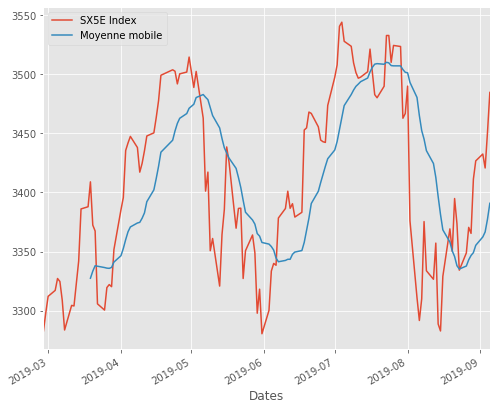

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Ajustement de la taille du matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Ajustement du style de matplotlib
style.use('ggplot')

close_px.plot(label='SX5E Index')
mavg.plot(label='Moyenne mobile')
plt.legend()

Dans ce graphique, la moyenne mobile montre la tendance à la hausse ou à la baisse du prix des actions. Logiquement, vous devriez acheter lorsque les actions connaissent une baisse et vendre lorsque les actions connaissent une hausse.

### Écart de rendement - pour déterminer le risque et le rendement
Le rendement attendu mesure la moyenne, ou valeur attendue, de la distribution de probabilité des rendements des placements. Le rendement prévu d'un portefeuille est calculé en multipliant le poids de chaque actif par son rendement prévu et en additionnant les valeurs de chaque placement.

Selon la formule, nous pourrions tracer nos rendements comme suit.

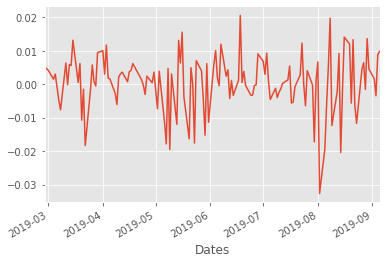

In [5]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

## Calcul de la volatilité
La volatilité d'une action est une mesure de la variation de la variance des rendements d'une action sur une période donnée. Il est courant de comparer la volatilité d'un titre à celle d'un autre titre pour avoir une idée de ce qui pourrait être moins risqué ou à celle d'un indice boursier pour examiner la volatilité du titre dans l'ensemble du marché. En général, plus la volatilité est élevée, plus le placement dans ce titre est risqué, ce qui fait que l'on investit dans l'un plutôt que dans l'autre.

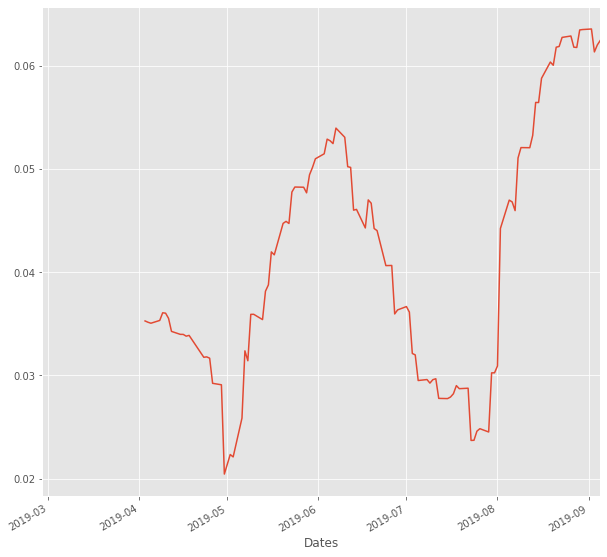

In [6]:
import numpy as np

# Attribué la colonne `SX5E Index` à `daily_close`
daily_close = data['SX5E Index']

# Daily returns
daily_pct_change = daily_close.pct_change()

# Nombre minimum de période à couvrir
min_periods = 25 

# Calcule de la volatilité
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Tracé de la volatilité
vol.plot(figsize=(10, 10))

# Affichage du graphique
plt.show()

### Classification : tester différents modèles pour prédire la variation du portefeuille.
Traitement de la base de données.

In [7]:
# Daily returns
daily_returns =data.pct_change() 

# On centre et normalise les données 
daily_returns_centered =(daily_returns - daily_returns.mean())/daily_returns.std()
daily_returns_centered.dropna(inplace=True)

# On cherche à faire de la classification : 1 s'il y a une augmentation 0 sinon.
Eurostoxx50 = daily_returns_centered["SX5E Index"].apply(lambda x : 0 if x <=0 else 1 ) 

# On souhaite déterminer la variation en j+1
Eurostoxx50 = Eurostoxx50.shift(-1)

Eurostoxx50.drop(Eurostoxx50.tail(1).index,inplace=True)
daily_returns_centered.drop(daily_returns_centered.tail(1).index,inplace=True)

#Suppression de la dernière colonne qu'on doit prédire
daily_returns_centered = daily_returns_centered.drop(["SX5E Index"], axis=1)

In [8]:
# Création d'un train set et un test set
# 70% pour le train et 20% pour le test
from sklearn import metrics
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(daily_returns_centered, Eurostoxx50, test_size=0.3)

1. Arbre de décision

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
tree_model = tree.fit(X_train,Y_train)
tree_prediction = tree_model.predict(X_test)
tree_precision = metrics.accuracy_score(Y_test, tree_prediction)
print("Précision:", tree_precision)

Précision: 0.525


2. AdaBoost

In [10]:
from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier()
boost_model = boost.fit(X_train,Y_train)
boost_prediction = boost_model.predict(X_test)
boost_precision = metrics.accuracy_score(Y_test, boost_prediction)
print("Précision:", boost_precision)

Précision: 0.375


3. RandomForest

In [11]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier() 
RandomForest_model = RandomForest.fit(X_train, Y_train)
RandomForest_prediction = RandomForest_model.predict(X_test)
RandomForest_precision = metrics.accuracy_score(Y_test, RandomForest_prediction)
print("Précision:", RandomForest_precision)

Précision: 0.45


/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


On observe que la précision est plus important avec l'arbre de décision.

## Analyse des autres stocks
Dans ce segment, nous allons analyser la performance d'un titre par rapport à son concurrent.

### Analyse de corrélation - Un concurrent a-t-il une influence sur les autres ?
Nous pouvons analyser la concurrence en exécutant la fonction de variation et de corrélation en pourcentage dans les pandas. La variation en pourcentage permet de déterminer de combien le prix change par rapport au jour précédent, ce qui définit les rendements. La connaissance de la corrélation nous aidera à voir si les rendements sont affectés par les rendements d'autres actions

In [12]:
retscomp = data.pct_change()
corr = retscomp.corr()

Let’s plot BAS GY Equity and SX5E Index with ScatterPlot to view their return distributions.

Text(0, 0.5, 'Returns SX5E Index')

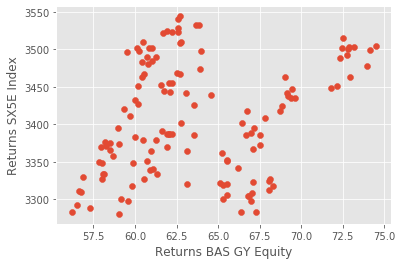

In [13]:
plt.scatter(data['BAS GY Equity'], data['SX5E Index'])
plt.xlabel("Returns BAS GY Equity")
plt.ylabel("Returns SX5E Index")

Améliorons encore notre analyse en traçant la scatter_matrix pour visualiser les corrélations possibles entre les titres concurrents. Au point diagonal, nous allons exécuter l'estimation de la densité du noyau (KDE). La KDE est un problème fondamental de lissage des données où l'on fait des inférences sur la population, à partir d'un échantillon de données fini. Il permet de générer des estimations des distributions globales.

Nous utiliserons des cartes thermiques pour visualiser les plages de corrélation entre les stocks concurrents. Notez que plus la couleur est claire, plus les deux stocks sont corrélés.

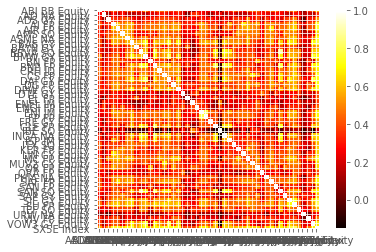

In [14]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

À partir de la matrice de dispersion et de la carte thermique, nous pouvons trouver de grandes corrélations entre les actions. Cependant, cela pourrait ne pas montrer de causalité et pourrait simplement montrer la tendance du portefeuille plutôt que de montrer comment ces actions s'influencent les unes les autres.

## Rendements des actions Taux et risque
Outre la corrélation, nous analysons également les risques et les rendements de chaque titre. Dans ce cas, nous extrayons la moyenne des rendements (Taux de rendement) et l'écart-type des rendements (Risque).

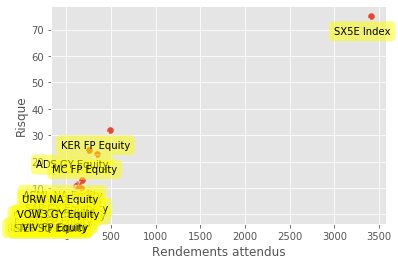

In [15]:
plt.scatter(data.mean(), data.std())

plt.xlabel('Rendements attendus')
plt.ylabel('Risque')

for label, x, y in zip(data.columns, data.mean(), data.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

Vous pouvez maintenant voir ce graphique soigné de comparaison des risques et des rendements des actions concurrentes. Logiquement, vous souhaitez minimiser le risque et maximiser les rendements. 

## Prévision du prix des actions
### Prétraitement et validation croisée
Nous allons nettoyer et traiter les données en suivant les étapes suivantes avant de les intégrer dans les modèles de prévision :
1. Supprimer la valeur manquante
2. En séparant l'étiquette ici, nous voulons prédire la valeur de AdjClose
3. Échelonner le X de façon à ce que tout le monde puisse avoir la même distribution pour la régression linéaire
4. Enfin, nous voulons trouver des séries de données de la fin X et du début X (train) pour la génération et l'évaluation de modèles
5. Étiqueter séparément et identifier comme y
6. Séparation de la formation et de l'essai du modèle par la validation croisée des essais du train

In [16]:
import math
import numpy as np
from sklearn import preprocessing

# Suppression de la valeur manquante
data.fillna(value=-99999, inplace=True)

# Nous voulons séparer 1 % des données pour la prédiction
forecast_out = int(math.ceil(0.01 * len(data)))

# On sépare l'étiquette SX5E car nous voulons prédire cet indice
X = np.array(data.drop(['SX5E Index'], axis=1))

# Mettre à l'échelle le X pour que tout le monde puisse avoir la même distribution pour la régression linéaire
X = preprocessing.scale(X)

# Enfin, nous voulons trouver des séries de données de la fin X et du début X (train) pour la génération et l'évaluation de modèles
X_lately = X[-forecast_out:]
X = X[:-forecast_out]

# Séparer l'étiquette et l'identifier comme y
y = np.array(data['SX5E Index'])
y_lately = y[-forecast_out:]
y = y[:-forecast_out]

## Génération du modèle - Où commence la prédiction ?
Mais d'abord, nous allons insérer les importations suivantes pour notre Scikit-Learn :

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

### Analyse linéaire simple et analyse discriminante quadratique
L'Analyse Linéaire Simple montre une relation linéaire entre deux ou plusieurs variables. Lorsque nous traçons cette relation à l'intérieur de deux variables, nous obtenons une ligne droite. L'Analyse Discriminante Quadratique serait similaire à l'Analyse Linéaire Simple, sauf que le modèle permettait un polynôme (par exemple : x au carré) et produirait des courbes.

La Régression Linéaire prédit les variables dépendantes (y) comme les sorties étant donné les variables indépendantes (x) comme les entrées. Lors du tracé, cela nous donnera une ligne droite.

Nous allons brancher et jouer la bibliothèque Scikit-Learn existante et entraîner le modèle en sélectionnant nos ensembles de trains X et y. Le code sera le suivant.

In [18]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)

# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

Pipeline(memory=None,
         steps=[('polynomialfeatures',
                 PolynomialFeatures(degree=3, include_bias=True,
                                    interaction_only=False, order='C')),
                ('ridge',
                 Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                       max_iter=None, normalize=False, random_state=None,
                       solver='auto', tol=0.001))],
         verbose=False)

### K Voisin le plus proche (KNN)
Le KNN utilise la similarité des caractéristiques pour prédire les valeurs des points de données. Cela garantit que le nouveau point affecté est similaire aux points de l'ensemble de données. Pour connaître la similarité, nous allons extraire les points pour libérer la distance minimale (p. ex. : distance euclidienne).

In [19]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=2)
clfknn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

## Évaluation
Une façon simple et rapide d'évaluer est d'utiliser la méthode de notation dans chaque modèle formé. La méthode de score trouve la précision moyenne de self.predict(X) avec y de l'ensemble des données du test.

In [20]:
confidencereg = clfreg.score(X_lately, y_lately)
confidencepoly2 = clfpoly2.score(X_lately, y_lately)
confidencepoly3 = clfpoly3.score(X_lately, y_lately)
confidenceknn = clfknn.score(X_lately, y_lately)

In [21]:
print("La confiance de la régression linéaire est ", confidencereg)
print("La confiance de la régression quadratique 2 est ", confidencepoly2)
print("La confiance de la régression quadratique 3 est ", confidencepoly3)
print("La confiance de régression knn est ", confidenceknn)

La confiance de la régression linéaire est  0.969497181241175
La confiance de la régression quadratique 2 est  -0.5211437721057464
La confiance de la régression quadratique 3 est  -0.5902458178150523
La confiance de régression knn est  -5.303576370828241


Cela montre un énorme score de précision (>0,95) pour le modèle de régression linéaire. Cependant, cela ne signifie pas que nous pouvons placer nos actions à l'aveuglette. Il y a encore beaucoup de questions à considérer.
Pour le test de santé mentale, imprimons quelques prévisions de stocks.

In [22]:
forecast_set = clfreg.predict(X_lately)
data['Forecast'] = np.nan

print(forecast_set)

[3452.8454701  3488.36523462]


## Tracer la prédiction
Sur la base de la prévision, nous visualiserons le tracé avec nos données historiques existantes. Cela nous aidera à visualiser le comportement du modèle pour prévoir l'évaluation future des actions.

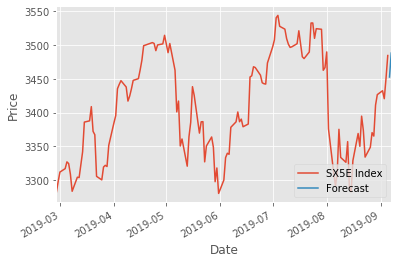

In [23]:
import datetime

last_date = data.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    data.loc[next_date] = [np.nan for _ in range(len(data.columns)-1)]+[i]
    
data['SX5E Index'].tail(1000).plot()
data['Forecast'].tail(1000).plot()

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

Comme on peut le voir, la couleur bleue a mis en évidence la prévision sur le prix des actions basée sur la régression. La prévision prévoyait qu'il y aurait une baisse pendant pas trop longtemps, puis qu'il y aurait une reprise. Par conséquent, nous pourrions acheter les actions pendant la baisse et vendre pendant la hausse.

## Features selection

La sélection de caractéristiques est un processus par lequel vous sélectionnez automatiquement les caractéristiques de vos données qui contribuent le plus à la variable de prédiction ou à la sortie qui vous intéresse.

Un trop grand nombre de caractéristiques non pertinentes dans vos données peut diminuer la précision des modèles. Les trois avantages de la sélection de caractéristiques avant de modéliser vos données sont les suivants :

Réduit le surajustement : Moins de données redondantes signifie moins de possibilités de prendre des décisions basées sur le bruit.
Améliore la précision : Moins de données trompeuses signifie une amélioration de la précision de la modélisation.
Réduit le temps de formation : Moins de données signifie que les algorithmes s'entraînent plus rapidement.
La bibliothèque Python Scikit-Learning propose deux méthodes de sélection de fonctionnalités différentes : l'élimination récursive des fonctionnalités et le classement par importance des fonctionnalités.

In [24]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso)

### Élimination récursive des caractéristiques
La méthode d'élimination récursive des caractéristiques (RFE) est une approche de sélection des caractéristiques. Elle fonctionne en supprimant récursivement les attributs et en construisant un modèle sur les attributs qui restent. Elle utilise la précision du modèle pour identifier les attributs (et combinaisons d'attributs) qui contribuent le plus à la prédiction de l'attribut cible.

Tout d'abord, nous créons une fonction qui sera capable de stocker facilement dans un dictionnaire Python nos classements de caractéristiques obtenus à partir des différentes méthodes décrites ici. 

In [25]:
# Définir un dictionnaire pour stocker nos classements
ranks = {}

# Stocker les noms des colonnes dans une liste "colnames"
colnames = data.columns


from sklearn.preprocessing import MinMaxScaler

# Créer une fonction qui stocke les classements des caractéristiques dans un dictionnaire
def ranking(ranks, names, order=1):
    minmax = MinMaxScaler()
    ranks = minmax.fit_transform(order*np.array([ranks]).T).T[0]
    ranks = map(lambda x: round(x,2), ranks)
    return dict(zip(names, ranks))

In [26]:
# Élimination récursive des caractéristiques
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression


# nous utilisons le modèle de régression linéaire
# arrêter la recherche quand il ne reste que la dernière fonctionnalité
rfe = RFE(clfreg, n_features_to_select=1, verbose =3 )
rfe.fit(X,y)
ranks["RFE"] = ranking(list(map(float, rfe.ranking_)), colnames, order=-1)

Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with 30 features.
Fitting estimator with 29 features.
Fitting estimator with 28 features.
Fitting estimator with 27 features.
Fitting estimator with 26 features.
Fitting estimator with 25 features.
Fitting estimator with 24 features.
Fitting estimator with 23 features.
Fitting estimator with 22 features.
Fitting estimator with 21 features.
Fitting estimator with 20 fe

### Classement des caractéristiques du modèle linéaire
Appliquons maintenant 3 modèles linéaires différents (Linéaire, Lasso et Régression de crête) et voyons comment les caractéristiques sont sélectionnées et priorisées via ces modèles. Pour cela, je vais utiliser l'implémentation sklearn de ces modèles et en particulier l'attribut .coef pour retourner les coefficients estimés pour chaque élément du modèle linéaire.

In [27]:
# Using Linear Regression
ranks["LinReg"] = ranking(np.abs(clfreg.coef_), colnames)

# Using Ridge 
ridge = Ridge(alpha = 7)
ridge.fit(X,y)
ranks['Ridge'] = ranking(np.abs(ridge.coef_), colnames)

# Using Lasso
lasso = Lasso(alpha=.05)
lasso.fit(X, y)
ranks["Lasso"] = ranking(np.abs(lasso.coef_), colnames)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 132.97457991887438, tolerance: 74.09733277969698
  positive)


### Classement aléatoire des caractéristiques de la forêt
Le modèle Random Forest de Sklearn est également doté de son propre attribut de classement des caractéristiques et il est possible de l'appeler simplement par " caractéristiques importantes ". C'est ce que nous allons utiliser comme suit :

In [28]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_jobs=-1, n_estimators=50, verbose=3)
rf.fit(X,y)
ranks["RF"] = ranking(rf.feature_importances_, colnames);

building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50

building tree 9 of 50
building tree 10 of 50building tree 11 of 50building tree 12 of 50building tree 13 of 50

building tree 14 of 50building tree 15 of 50



building tree 16 of 50
building tree 17 of 50
building tree 18 of 50
building tree 19 of 50building tree 20 of 50building tree 21 of 50

building tree 22 of 50building tree 23 of 50


building tree 24 of 50
building tree 25 of 50
building tree 26 of 50building tree 27 of 50building tree 28 of 50


building tree 29 of 50building tree 30 of 50

building tree 31 of 50building tree 32 of 50

building tree 33 of 50
building tree 34 of 50
building tree 35 of 50building tree 36 of 50

building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50building tree 42 of 50

building tree 43 of 50building tree 44 of 5

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.1s finished


### Création de la matrice de classement des fonctions
Nous combinons les scores des différentes méthodes ci-dessus et les affichons sous forme de matrice pour une visualisation pratique :

In [29]:
FeatureMatrix = pd.DataFrame.from_dict(ranks)
FeatureMatrix['Mean'] = FeatureMatrix.mean(numeric_only=True, axis=1)

In [30]:
print(FeatureMatrix[:10])

                 RFE  LinReg  Ridge  Lasso    RF   Mean
ABI BB Equity   0.72    0.42   0.41   0.35  0.00  0.380
AD NA Equity    0.78    0.19   0.10   0.07  0.01  0.230
ADS GY Equity   0.54    0.46   0.60   0.20  0.00  0.360
AI FP Equity    0.24    0.28   0.71   0.60  0.00  0.366
AIR FP Equity   0.57    0.31   0.72   0.40  0.02  0.404
AMS SQ Equity   0.11    0.13   0.49   0.27  0.00  0.200
ASML NA Equity  0.96    0.83   0.69   0.92  0.10  0.700
BAS GY Equity   0.93    0.37   0.40   0.22  0.01  0.386
BAYN GY Equity  0.74    0.56   0.43   0.56  0.00  0.458
BBVA SQ Equity  0.02    0.02   0.33   0.00  0.00  0.074


Maintenant, avec la matrice ci-dessus, les chiffres et la disposition ne semblent pas très faciles ou agréables à l'œil. Par conséquent, nous allons simplement rassembler la note moyenne de classement attribuée à chaque élément et la reporter sur le graphique factoriel de Seaborn.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


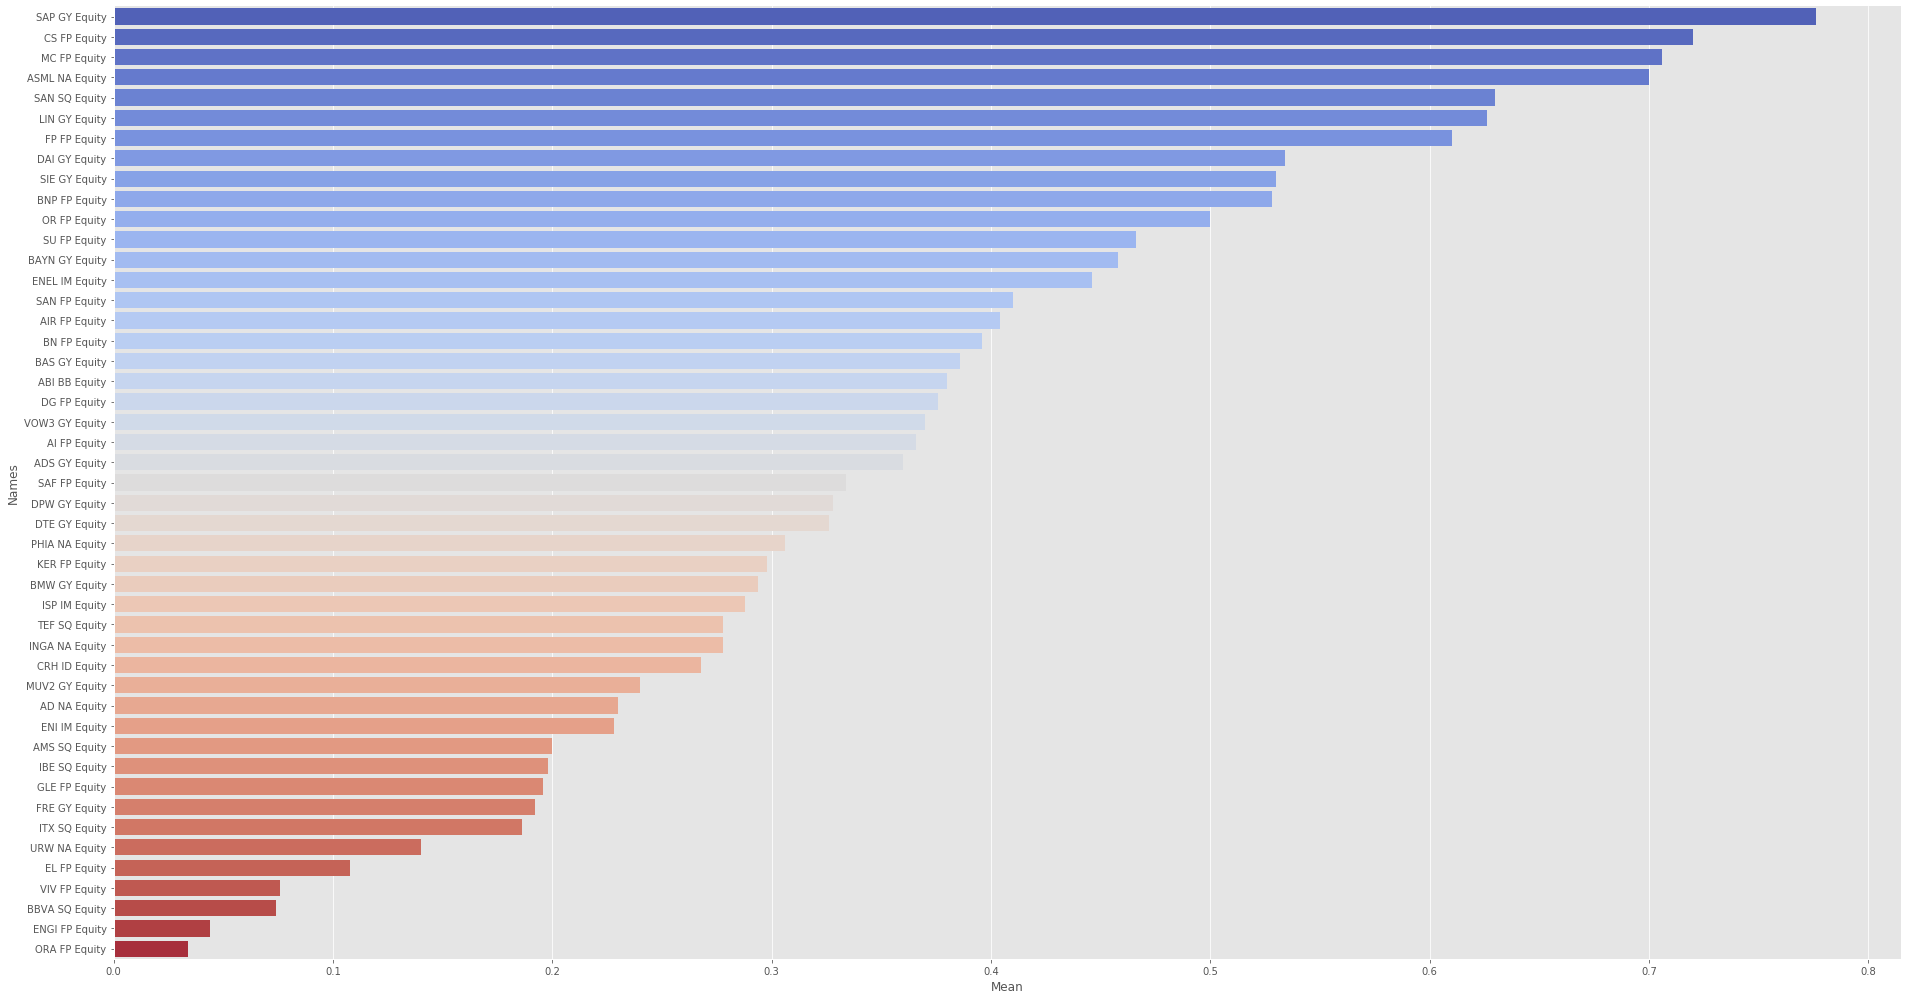

In [31]:
# Put the mean scores into a Pandas dataframe
meanplot = FeatureMatrix[['Mean']]
meanplot['Names'] = FeatureMatrix.index

# Sort the dataframe
meanplot = meanplot.sort_values('Mean', ascending=False)

import seaborn as sns
# Let's plot the ranking of the features
sns.factorplot(x="Mean", y="Names", data = meanplot, kind="bar", 
               size=14, aspect=1.9, palette='coolwarm')

In [32]:
print(meanplot[:10])

                 Mean           Names
SAP GY Equity   0.776   SAP GY Equity
CS FP Equity    0.720    CS FP Equity
MC FP Equity    0.706    MC FP Equity
ASML NA Equity  0.700  ASML NA Equity
SAN SQ Equity   0.630   SAN SQ Equity
LIN GY Equity   0.626   LIN GY Equity
FP FP Equity    0.610    FP FP Equity
DAI GY Equity   0.534   DAI GY Equity
SIE GY Equity   0.530   SIE GY Equity
BNP FP Equity   0.528   BNP FP Equity


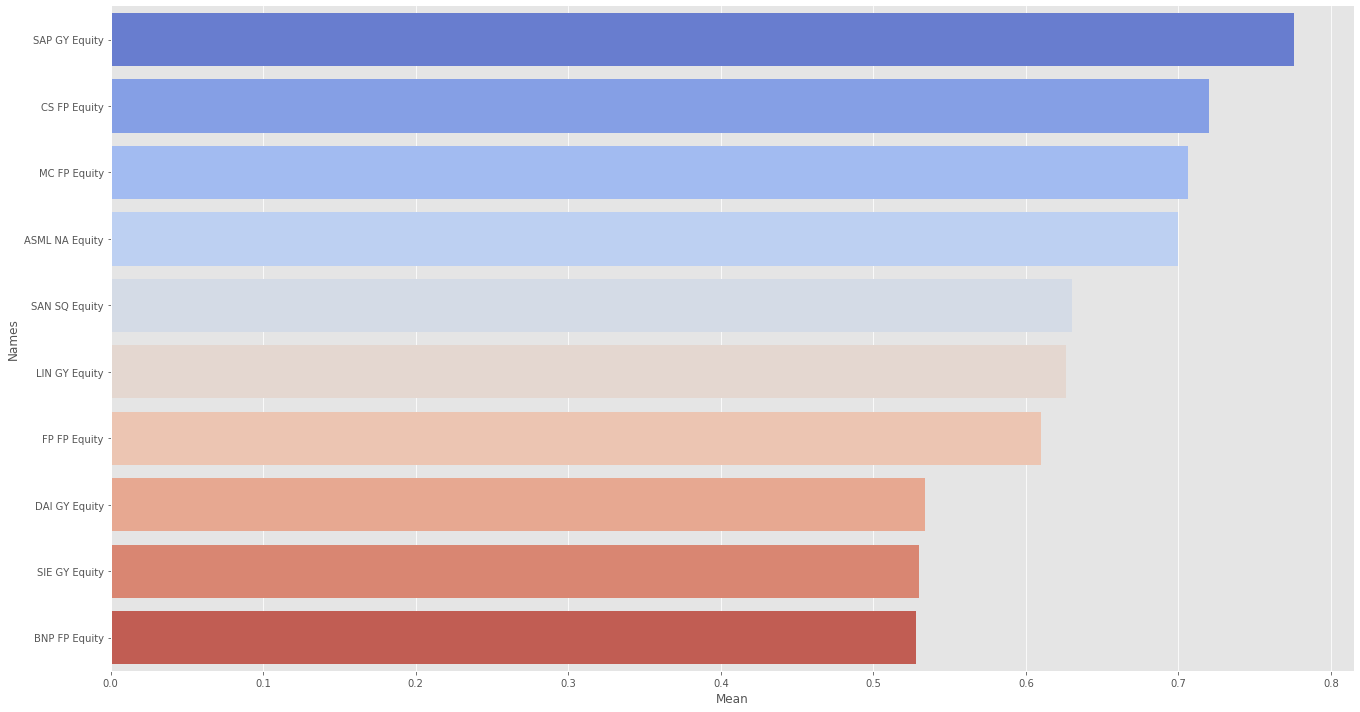

In [33]:
# Let's plot the ranking of the features
sns.factorplot(x="Mean", y="Names", data = meanplot[:10], kind="bar", 
               size=10, aspect=1.9, palette='coolwarm')

### The Efficient Frontier: l'optimisation du portefeuille de Markowitz

In [34]:
import cvxopt as opt  
from cvxopt import blas, solvers  

Text(0, 0.5, 'price in $')

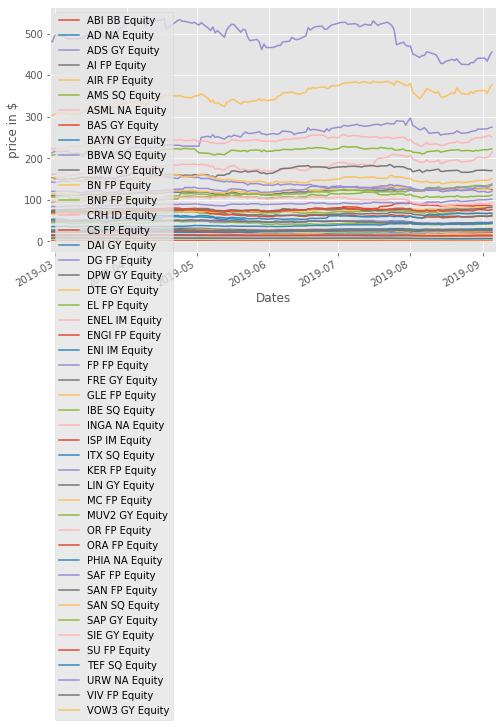

In [35]:
new_data = data.drop(['SX5E Index', 'Forecast'], axis=1)
new_data.loc[:, :].plot(figsize=(8,5))  
plt.ylabel('price in $')  